# Used Car Prices

A final project for DTSA-5509, Supervised Learning. The goal for this project is to use a dataset of used car listings gathered to predict the price of a vehicle before listing it for sale.

For this dataset, I am going to explore using simple linear regression and multi-linear regression for price prediction. I suspect the multi-linear regression will give the best results due to how dependant year, make, and model are when considering the price of a vehicle along with other features like the odometer reading.

## About the Data

The dataset I am using was scraped from the website Craigslist.org by Austin Reese and was made available on Kaggle.com. The source code for the web scrapper is available on github at https://github.com/AustinReese/UsedVehicleSearch.

A recent version of the dataset can be downloaded from https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

The dataset is over 1.45GB, uncompressed, so it is not included in the github repo for this notebook and must be download separately and placed in a `data` subdirectory to run.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
df = pd.read_csv("data/vehicles.csv")
df.head(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
print("The dataset has ", len(df), " rows and ", len(df.columns), " features.")

The dataset has  426880  rows and  26  features.


There are 26 features in this dataset. I will use one feature, price, as the target. A few of the remaining features will probably not be needed for price prediction. These are features that uniquely identify the particular vehicle such as `id` and `VIN` and web resource features like `url`, `region_url`, and `image_url`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [5]:
df.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


The data isn't very clean. Most of the features were cast as object instead of string, category, or numeric. Many features have null data, and there are a lot of outliers in the numeric features. For example, price has a max value of 3.7 billion dollars.

## Data Cleaning

For cleaning the data before doing an EDA and modeling, I'm going to first look at features with excessive null values (over 5% null) and throw them out. With the remaining features that might need imputing, it will come down to a feature-by-feature basis if the data is filled in with an average or if the row with missing data will be rejected from the dataset.

It is possible to systematically fill in missing by using an expensive third-party service, like vinquery.com, to decode the VIN number. But I will not be using a VIN decoder for this project due to the cost of the service.

Because of the size of the dataset, throwing out rows with null features can be an option.

In [6]:
null_counts = pd.Series(list(df.isnull().sum()))
print(null_counts)

features_df = df.drop("price", axis = 1)

imputation_condition = 0.05

bool_throw = null_counts[0:-1] / len(features_df) > imputation_condition
bool_keep = null_counts[0:-1] / len(features_df) <= imputation_condition

features_to_impute = list(features_df.columns[bool_keep])
features_to_throw = list(features_df.columns[bool_throw])

print("Features to impute ", len(features_to_impute), features_to_impute)
print("Features to throw ", len(features_to_throw), features_to_throw)

clean_df = df.replace(0, np.nan)
clean_df = clean_df.drop(features_to_throw, axis = 1)

0          0
1          0
2          0
3          0
4          0
5       1205
6      17646
7       5277
8     174104
9     177678
10      3013
11      4400
12      8242
13      2556
14    161042
15    130567
16    306361
17     92858
18    130203
19        68
20        70
21    426880
22         0
23      6549
24      6549
25        68
dtype: int64
Features to impute  17 ['id', 'url', 'region', 'region_url', 'year', 'manufacturer', 'model', 'condition', 'odometer', 'title_status', 'transmission', 'VIN', 'description', 'county', 'lat', 'long', 'posting_date']
Features to throw  8 ['cylinders', 'fuel', 'drive', 'size', 'type', 'paint_color', 'image_url', 'state']


Besides unqiuely identifying features like `id` and `vin` and web urls, I've decided to throw `county` (100% missing), `description` (large amount of unstructured text), and `lat` and `long` (too granular when region is available). 

In [7]:
more_throw_features = ["id", "VIN", "url", "region_url", "county", "description", "lat", "long"]
clean_df = clean_df.drop(more_throw_features, axis = 1)

In [8]:
clean_df

,region,price,year,manufacturer,model,condition,odometer,title_status,transmission,posting_date
0,prescott,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fayetteville,11900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,florida keys,21000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,worcester / central MA,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,greensboro,4900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590.0,2019.0,nissan,maxima s sedan 4d,good,32226.0,clean,other,2021-04-04T03:21:31-0600
426876,wyoming,30590.0,2020.0,volvo,s60 t5 momentum sedan 4d,good,12029.0,clean,other,2021-04-04T03:21:29-0600
426877,wyoming,34990.0,2020.0,cadillac,xt4 sport suv 4d,good,4174.0,clean,other,2021-04-04T03:21:17-0600
426878,wyoming,28990.0,2018.0,lexus,es 350 sedan 4d,good,30112.0,clean,other,2021-04-04T03:21:11-0600


In [9]:
columns_table = []
for c in clean_df.columns:
    null_count = clean_df[c].isnull().sum()
    columns_table.append([clean_df.dtypes[c], null_count, null_count / len(clean_df)])

columns_df = pd.DataFrame(columns_table, columns=["type", "null rows", "null percentage"], index=clean_df.columns)
print(columns_df)

                 type  null rows  null percentage
region         object          0         0.000000
price         float64      32895         0.077059
year          float64       1205         0.002823
manufacturer   object      17646         0.041337
model          object       5277         0.012362
condition      object     174104         0.407852
odometer      float64       6365         0.014911
title_status   object       8242         0.019308
transmission   object       2556         0.005988
posting_date   object         68         0.000159


Text(0.5, 1.0, 'Condition')

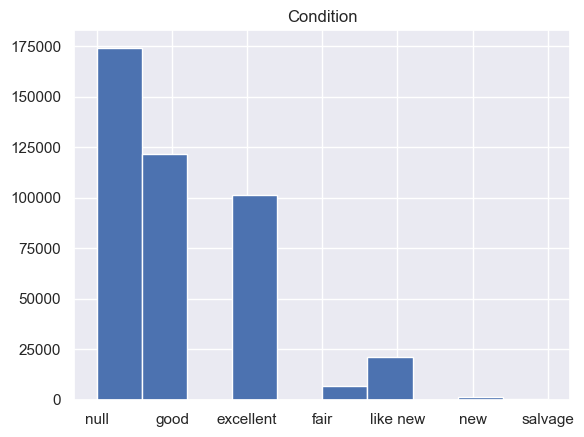

In [10]:
plt.hist(clean_df["condition"].fillna("null"))
plt.title("Condition")

Condition has the highest percentage of null rows of the features kept, and null is the most numerous value. My initial thought was to fill the null values with "good" or "fair" before I saw the visual representation of the feature. Since condition is very subjective and applying a default value may greatly affect the proportions, I've decided to drop condition as a feature. It also would've been dropped if I had chosen 4% instead of 5% as the imputation condition value.

In [11]:
clean_df = clean_df.drop(["condition"], axis = 1)

In [12]:
clean_df = clean_df.dropna()

In [13]:
clean_df['region'] = clean_df['region'].astype("str")
clean_df['manufacturer'] = clean_df['manufacturer'].astype("str")
clean_df['model'] = clean_df['model'].astype("str")
clean_df['title_status'] = clean_df['title_status'].astype("str")
clean_df['transmission'] = clean_df['transmission'].astype("str")

clean_df['year'] = clean_df['year'].astype(int)
clean_df['odometer'] = clean_df['odometer'].astype(int)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361882 entries, 27 to 426879
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        361882 non-null  object 
 1   price         361882 non-null  float64
 2   year          361882 non-null  int64  
 3   manufacturer  361882 non-null  object 
 4   model         361882 non-null  object 
 5   odometer      361882 non-null  int64  
 6   title_status  361882 non-null  object 
 7   transmission  361882 non-null  object 
 8   posting_date  361882 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 27.6+ MB


### Dealing with Outliers

Price and odometer have a few very large outliers that may skew the data.


Text(0.5, 1.0, 'Boxplot of price (in USD)')

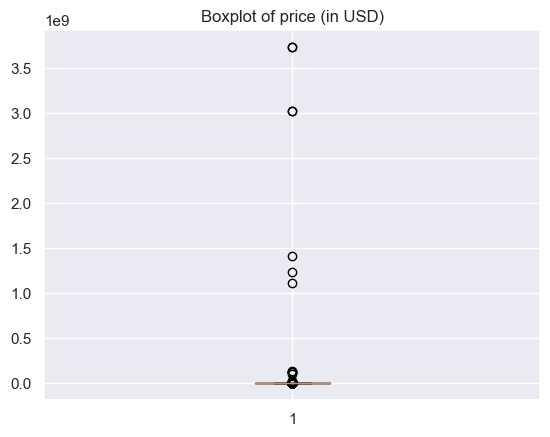

In [14]:
plt.boxplot(clean_df['price'])
plt.title("Boxplot of price (in USD)")

Text(0.5, 1.0, 'Boxplot of odometer (in miles), outliers removed')

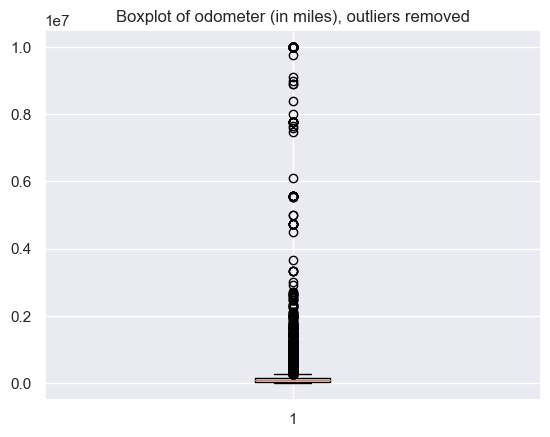

In [15]:
plt.boxplot(clean_df['odometer'])
plt.title("Boxplot of odometer (in miles), outliers removed")

In [16]:
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    print("Upper ", feature, ": ", upper_limit)
    print("Lower ", feature, ": ", lower_limit)

    # For the needs of this notebook, negatives should be removed
    return upper_limit, max(lower_limit, 0)

p_upper, p_lower = outliers(clean_df, "price")
odo_upper, odo_lower = outliers(clean_df, "odometer")

clean_df = clean_df[(clean_df['price'] > p_lower) & (clean_df['price'] < p_upper)]
clean_df['year'] = clean_df['year'].astype(int)

clean_df = clean_df[(clean_df['odometer'] > odo_lower) & (clean_df['odometer'] < odo_upper)]
clean_df['odometer'] = clean_df['odometer'].astype(int)

Upper  price :  58507.5
Lower  price :  -23112.5
Upper  odometer :  280274.625
Lower  odometer :  -106724.375


Text(0.5, 1.0, 'Boxplot of price (in USD), outliers removed')

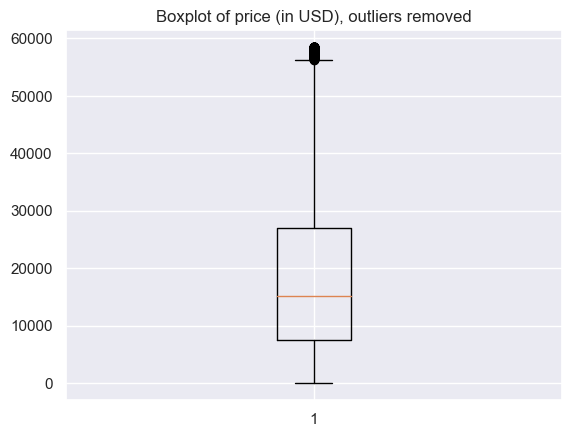

In [17]:
plt.boxplot(clean_df['price'])
plt.title("Boxplot of price (in USD), outliers removed")

Text(0.5, 1.0, 'Boxplot of odometer (in miles), outliers removed')

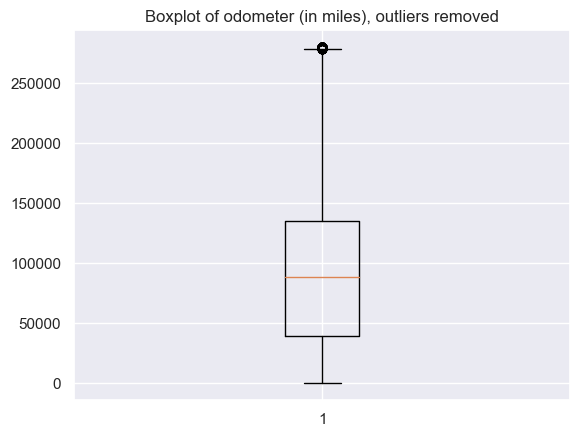

In [18]:
plt.boxplot(clean_df['odometer'])
plt.title("Boxplot of odometer (in miles), outliers removed")

Both the price and odometer had negative lower bounds, which shouldn't be possible, so when cleaning the data, I removed anything below 0. The data looks a lot better with global outliers removed.

In [19]:
clean_df.describe()

,price,year,odometer
count,352823.000000,352823.000000,352823.000000
mean,18031.349028,2011.435145,92105.078895
std,12757.938866,8.579149,60566.386854
min,1.000000,1900.000000,1.000000
25%,7450.000000,2008.000000,39336.000000
50%,15200.000000,2013.000000,88000.000000
75%,26990.000000,2017.000000,135000.000000
max,58500.000000,2022.000000,280200.000000


In [20]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352823 entries, 27 to 426879
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        352823 non-null  object 
 1   price         352823 non-null  float64
 2   year          352823 non-null  int64  
 3   manufacturer  352823 non-null  object 
 4   model         352823 non-null  object 
 5   odometer      352823 non-null  int64  
 6   title_status  352823 non-null  object 
 7   transmission  352823 non-null  object 
 8   posting_date  352823 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 26.9+ MB


After proper type casting, removing nulls features and removing null or global outlier rows, we still have over 350,000 used cars to represent the market.

## EDA

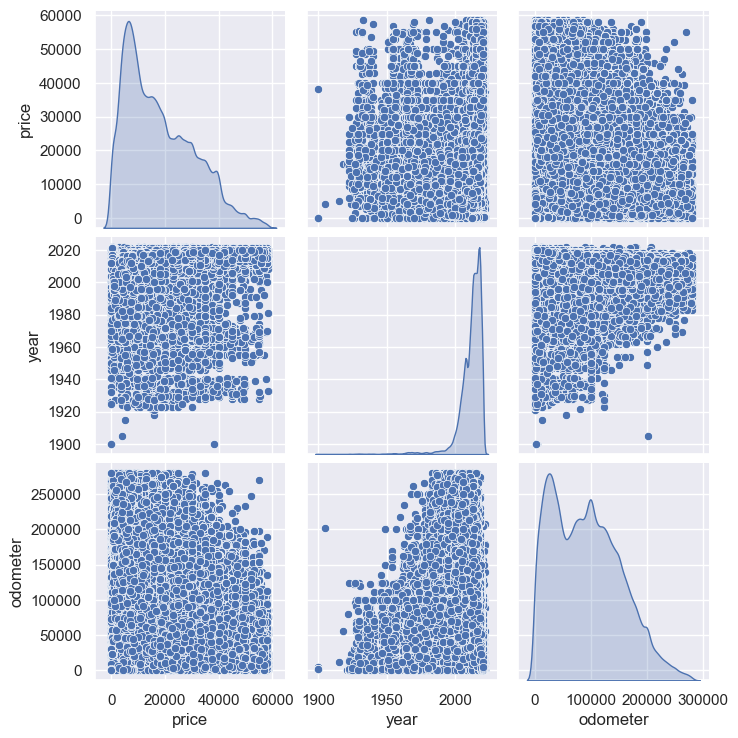

In [21]:
sns.pairplot(clean_df, diag_kind = "kde")

At first, it looks like there will be a strong correlation between the numeric values in the dataset. However, it actually is just the shape of the data.

Text(0.5, 1.0, 'Histogram of prices (in USD)')

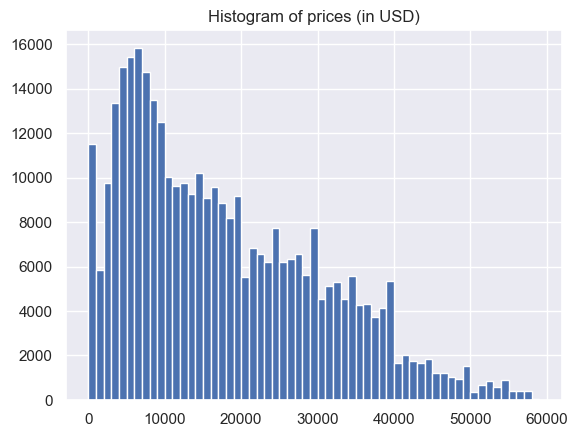

In [22]:
prices = clean_df['price'].astype(int)
binwidth = 1000
bins = range(min(prices), max(prices) + binwidth, binwidth)
plt.hist(prices, bins=bins)
plt.title("Histogram of prices (in USD)")

Text(0.5, 1.0, 'Histogram of Odometer Readings (in miles)')

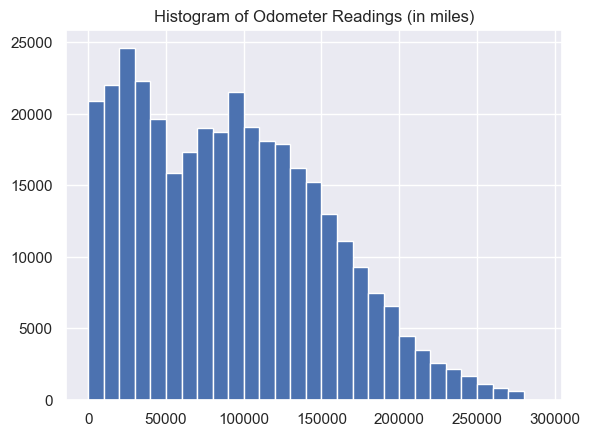

In [23]:
miles = clean_df['odometer']
binwidth = 10000
bins = range(min(miles), max(miles) + binwidth, binwidth)
plt.hist(miles, bins=bins)
plt.title("Histogram of Odometer Readings (in miles)")

Text(0.5, 1.0, 'Histogram of Years')

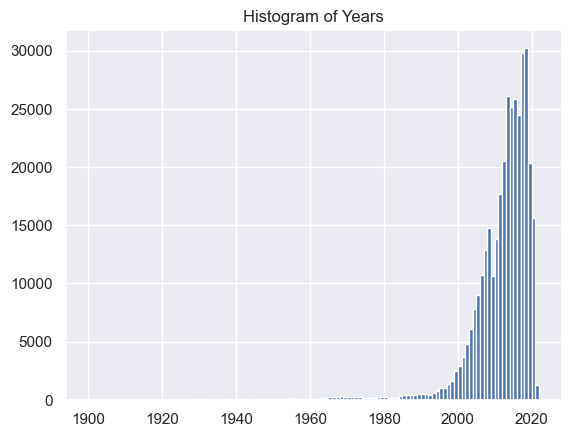

In [24]:
years = clean_df['year']
binwidth = 1
bins = range(min(years), max(years) + binwidth, binwidth)
plt.hist(years, bins=bins)
plt.title("Histogram of Years")

<AxesSubplot: >

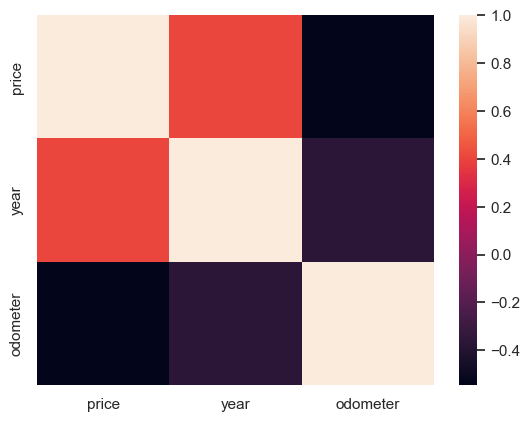

In [25]:
corr = clean_df.corr(numeric_only=True)
sns.heatmap(corr)

There is a stronger correlation between year and price than odometer reading and price.

In [26]:
print(clean_df.groupby('manufacturer')['price'].median())

manufacturer
acura              19998.0
alfa-romeo         29590.0
aston-martin       37000.0
audi               23998.0
bmw                17998.0
buick              12995.0
cadillac           17590.0
chevrolet          15950.0
chrysler            7995.0
datsun             17950.0
dodge              11000.0
ferrari            14000.0
fiat               10595.0
ford               16950.0
gmc                23000.0
harley-davidson    11975.0
honda               8998.0
hyundai            10588.0
infiniti           21590.0
jaguar             28990.0
jeep               18449.5
kia                11802.0
land rover          7995.0
lexus              19995.0
lincoln            18844.0
mazda               9995.0
mercedes-benz      18525.0
mercury             4495.0
mini               12998.0
mitsubishi         15990.0
nissan             10000.0
pontiac             4987.5
porsche            26995.0
ram                29995.0
rover              24990.0
saturn              4235.5
subaru         

When looking for a stronger indicator of price, manufacturer is a good option to test in the model. And this makes sense in context. Nissan has a median price of $10,000, but their very own luxury brand, Infiniti, has a median price of $21,590.

## Model Training

First, I'm splitting the dataset so 20% is used for testing with the remaining used for training.

In [27]:
x_train, x_test = train_test_split(clean_df, test_size = 0.20, random_state = 100)

For a simple linear regression using Ordinary Least Squares, I'm reviewing the summary from year, odometer, and manufacturer.

In [28]:
year_model = smf.ols('price ~ year', x_train)
year_result = year_model.fit()
print(year_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                 5.685e+04
Date:                Tue, 07 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:36:43   Log-Likelihood:            -3.0431e+06
No. Observations:              282258   AIC:                         6.086e+06
Df Residuals:                  282256   BIC:                         6.086e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.209e+06   5145.830   -234.937      0.0

In [29]:
odo_model = smf.ols('price ~ odometer', x_train)
odo_result = odo_model.fit()
print(odo_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                 1.185e+05
Date:                Tue, 07 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:36:43   Log-Likelihood:            -3.0195e+06
No. Observations:              282258   AIC:                         6.039e+06
Df Residuals:                  282256   BIC:                         6.039e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.857e+04     36.682    778.882      0.0

In [30]:
make_model = smf.ols('price ~ manufacturer', x_train)
make_result = make_model.fit()
print(make_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     937.8
Date:                Tue, 07 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:36:44   Log-Likelihood:            -3.0514e+06
No. Observations:              282258   AIC:                         6.103e+06
Df Residuals:                  282217   BIC:                         6.103e+06
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Multiple Linear Regression

In [31]:
model = smf.ols("""price ~ year + odometer""", x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                 7.466e+04
Date:                Tue, 07 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:36:44   Log-Likelihood:            -3.0090e+06
No. Observations:              282258   AIC:                         6.018e+06
Df Residuals:                  282255   BIC:                         6.018e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.967e+05   4920.905   -141.578      0.0

In [32]:
model = smf.ols("""price ~ year 
                        + odometer
                        + manufacturer""", x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     5678.
Date:                Tue, 07 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:36:45   Log-Likelihood:            -2.9825e+06
No. Observations:              282258   AIC:                         5.965e+06
Df Residuals:                  282215   BIC:                         5.966e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Results and Analysis

Single feature models cannot really predict the price of a vehicle, and multi feature models get better. 

The results of the simple linear regression trainings are a little different than I was expecting. I was expecting Manufacturer to have a higher $R^2$ value.

| Feature    | $R^2$ |
|------------|-------|
|Year        | 0.168 |
|Odometer    | 0.296 |
|Manufacture | 0.117 |

In [33]:
features = ['region', 'year', 'manufacturer', 'odometer', 'title_status', 'transmission'] # excluding model

best = ['', 0]
for p in features:
    model = smf.ols(formula ='price ~ ' + p, data=x_train).fit()
    print(p, model.rsquared)
    if model.rsquared > best[1]:
        best = [p, model.rsquared]
print('best: ', best)

train_best = smf.ols(formula='price ~ ' + best[0], data=x_train).fit()
print(train_best.model.formula)
train_best.rsquared_adj

region 0.07158470794563987
year 0.1676572571440449
manufacturer 0.11732619768155739
odometer 0.2956633041245065
title_status 0.010122175352893614
transmission 0.1321795366893388
best:  ['odometer', 0.2956633041245065]
price ~ odometer


0.29566080874196055

When testing all allowed features for a simple linear regression, Odometer did end up being the best.

Best $R^2$ for a multi feature model was **0.458** with year, odometer, and manufacturer.

## Conclusion

The best model I ultimately ended up with was a multi linear model using the features: year + odometer + manufacturer. I don't think it's good enough to provide pricing guidance. I believe adding "model" (as in the vehicle's model name) to the training model would greatly improve it's ability to predict the price of a vehicle. However, I could never get a model to finish when adding that feature, even a simple OLS with only that feature.

It makes sense that model name would help. Not only are there wide price differences between large volume manufacturers like Ford and Honda and luxury car manufacturers like BMW and Infiniti, there are large differences within the product range of a manufacturer. A Mazda 3 Sedan starts around $22k and a Mazda CX-90 SUV starts around $40k.

I'm unsure how to speed up computing the training model when including the full model name of a vehicle. This could point to the feature needs more processing or OLS not being the right model for this dataset. When spot checking the data, I think breaking trim level out from the model name would help improve the model by reducing the number of unique values for the feature. Cleaning up the model name more would be greatly improved with the use of a VIN decoding service.
